In [41]:
####importing necessary packages#######
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import wandb
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [53]:
import tqdm
tqdm.__version__

'4.64.1'

In [20]:
# Initializing a new Weights & Biases run with the specified project name
project_name='With attention'
wandb.login(key="5bfaaa474f16b4400560a3efa1e961104ed54810")
wandb.init(project=project_name)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PhysioSens\.netrc


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [42]:
train_data=pd.read_csv(r'data\mal_train.csv') # Load training data from CSV file
val_data=pd.read_csv(r'data/mal_valid.csv')# Load validation data from CSV file
test_data=pd.read_csv(r'data/mal_test.csv') # Load test data from CSV file


In [43]:
eng_train = train_data['English']  # Extract English training data
mal_train = train_data['Malayalam']  # Extract Malayalam training data
eng_val = val_data['English']  # Extract English validation data
mal_val = val_data['Malayalam']  # Extract Malayalam validation data
eng_test = test_data['English']  # Extract English test data
mal_test = test_data['Malayalam']  # Extract Malayalam test data
english_all = pd.concat([eng_train, eng_val, eng_test], ignore_index=True)  # Concatenate all English data
malayalam_all = pd.concat([mal_train, mal_val, mal_test], ignore_index=True)  # Concatenate all Malayalam data


In [4]:
def unique_char(lan):
    unique_cha = ''  # Initialize an empty string to store unique characters
    for word in lan:  # Iterate through each word in the list
        for char in word:  # Iterate through each character in the word
            if char not in unique_cha:  # Check if the character is not already in the unique_cha string
                unique_cha += char  # Append the unique character to the string
    return unique_cha  # Return the string containing all unique characters


In [5]:
class LANG:
    def __init__(self, lang):
        self.lang = lang  # Initialize the language data
        self.word2index = {}  # Dictionary to map characters to indices
        self.index2word = {0: 'SOS', 1: 'EOS'}  # Dictionary to map indices to characters
        self.max_length = 0  # Variable to store the length of the longest word
        self.count = 2  # Counter for indexing, starting after SOS and EOS
        self.max_word = ''  # Variable to store the longest word

    def addchar(self):
        for word in self.lang:  # Iterate through each word in the language data
            length = len(word)  # Get the length of the current word
            if length > self.max_length:  # Check if the current word is the longest so far
                self.max_length = length  # Update the maximum word length
                self.max_word = word  # Update the longest word
            for char in word:  # Iterate through each character in the word
                if char not in self.word2index:  # Check if the character is not already indexed
                    self.word2index[char] = self.count  # Assign the current count as the index
                    self.index2word[self.count] = char  # Map the current count to the character
                    self.count += 1  # Increment the counter
        return self.word2index, self.index2word, self.max_length, self.max_word  # Return the mappings and max values


In [44]:
# Initialize language objects for English and Malayalam
eng = LANG(english_all)
# Get mappings and max values for English
eng_word2index, eng_index2word, eng_maxlength, eng_word = eng.addchar()
access_eng = eng_word2index, eng_index2word, eng_maxlength, eng_word

mal = LANG(malayalam_all)
# Get mappings and max values for Malayalam
mal_word2index, mal_index2word, mal_maxlength, mal_word = mal.addchar()
access_mal = mal_word2index, mal_index2word, mal_maxlength, mal_word

In [7]:
def Tensorpair(eng, mal, access_eng, access_mal):
    # Unpack access_eng and access_mal
    eng_word2index, eng_index2word, eng_maxlength, eng_word = access_eng
    mal_word2index, mal_index2word, mal_maxlength, mal_word = access_mal
    
    n = len(eng)
    # Initialize tensors for input and target sequences
    input_ids = torch.zeros((n, eng_maxlength + 1), dtype=torch.int32)
    target_ids = torch.zeros((n, eng_maxlength + 1), dtype=torch.int32)
    
    for i, (eng_word, mal_word) in enumerate(zip(eng, mal)):
        try:
            # Convert characters to indices using word2index mappings
            input_indx = [eng_word2index[char] for char in eng_word]
            input_indx.append(1)  # Append EOS token index
            input_indx = torch.tensor(input_indx, dtype=torch.long)
            
            target_indx = [mal_word2index[char] for char in mal_word]
            target_indx.append(1)  # Append EOS token index
            target_indx = torch.tensor(target_indx, dtype=torch.long)
            
            # Update input and target tensors
            input_ids[i, :len(input_indx)] = input_indx
            target_ids[i, :len(target_indx)] = target_indx
        except Exception as e:
            print(e)  # Print any exception that occurs
    
    # Create a TensorDataset from input and target tensors
    tensor_data = TensorDataset(input_ids, target_ids)
    
    return tensor_data


In [45]:
# Generating tensor pairs for training, validation, and testing data
train_data=Tensorpair(eng_train,mal_train,access_eng,access_mal)
val_data=Tensorpair(eng_val,mal_val,access_eng,access_mal)
test_data=Tensorpair(eng_test,mal_test,access_eng,access_mal)


In [9]:
# Setting batch size and creating data loaders for training, validation, and testing
batch_size=64
train_loader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(dataset=val_data,batch_size=batch_size,drop_last=True)
test_loader=DataLoader(dataset=test_data,batch_size=batch_size,drop_last=True)

In [10]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=512, num_layers=2, drop_out=0.2, embedding_size=256, bidirection=False, model='LSTM'):
        super().__init__()
        # Initialize the embedding layer
        self.embedding = nn.Embedding(len(eng_index2word), embedding_size)
        # Define the parameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop_out = drop_out
        # Choose the RNN model (LSTM/GRU/RNN)
        if model == 'LSTM':
            self.model = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirection, batch_first=True)
        elif model == 'GRU':
            self.model = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirection, batch_first=True)
        elif model == 'RNN':
            self.model = nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=bidirection, batch_first=True)
        else:
            raise ValueError('Given model is not found')
        # Apply dropout regularization
        self.drop_out = nn.Dropout(p=drop_out)
    
    def forward(self, input):
        # Embed the input sequence
        embedded = self.drop_out(self.embedding(input))
        # Pass the embedded sequence through the RNN model
        output, hidden = self.model(embedded)
        return output, hidden


In [46]:
class Decoder(nn.Module):
    def __init__(self, hidden_size=512, num_layers=2, drop_out=0.2, embedding_size=256, bidirection=False, model='LSTM'):
        super().__init__()
        # Initialize the embedding layer
        self.embedding = nn.Embedding(len(mal_index2word), embedding_size)
        # Define the parameters
        self.hidden_size = hidden_size
        self.num_layer = num_layers
        self.drop_out = drop_out
        # Choose the RNN model (LSTM/GRU/RNN)
        if model == 'LSTM':
            self.model = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirection, batch_first=True)
        elif model == 'GRU':
            self.model = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirection, batch_first=True)
        elif model == 'RNN':
            self.model = nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=bidirection, batch_first=True)
        else:
            raise ValueError('Given model is not found')
        # Apply dropout regularization
        self.drop_out = nn.Dropout(p=drop_out)
        # Define the output layer
        if bidirection:
            self.out = nn.Linear(4 * hidden_size, len(mal_index2word))
        else:
            self.out = nn.Linear(2 * hidden_size, len(mal_index2word))
    
    def Attention(self, decoder_output, encoder_output):
        # Calculate attention scores
        score = (decoder_output @ encoder_output.transpose(1, 2))
        # Apply softmax to get attention weights
        weight = F.softmax(score, dim=-1)
        # Calculate the context vector
        content = weight @ encoder_output
        return content, weight
    
    def forward(self, input, hidden, encoder_output):
        # Embed the input sequence
        embedded = self.drop_out(self.embedding(input))
        # Pass the embedded sequence through the RNN model
        output, hidden = self.model(embedded, hidden)
        # Compute attention and get context vector
        content, weight = self.Attention(output, encoder_output)
        # Concatenate output with context vector
        final = torch.cat([output, content], dim=-1)
        # Predict the output
        pred = self.out(final)
        return pred, hidden, weight


In [47]:
class seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        # Initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, inputs, targets, teacher_force_ratio):
        # Pass the input sequence through the encoder
        encoder_output, encoder_hidden = self.encoder(inputs)
        # Initialize the decoder input with zeros
        decoder_input = torch.empty(targets.shape[0], 1, dtype=torch.long, device='cuda').fill_(0)
        decoder_hidden = encoder_hidden
        # Initialize the output tensor
        output = torch.zeros((targets.shape[0], targets.shape[1], len(mal_index2word)), device='cuda')
        # Initialize the list to store attention weights
        attention = []
        
        for i in range(output.shape[1]):
            # Pass the decoder input, hidden state, and encoder output through the decoder
            pred, decoder_hidden, weight = self.decoder(decoder_input, decoder_hidden, encoder_output)
            # Append the attention weights to the list
            attention.append(weight)
            pred = torch.squeeze(pred)
            # Store the predicted output
            output[:, i, :] = pred
            # Update the decoder input for the next time step
            best_guess = torch.argmax(pred, axis=-1).view(-1, 1)
            decoder_input = best_guess if np.random.rand() > teacher_force_ratio else targets[:, i].view(-1, 1)
            # Keep the decoder hidden state unchanged
            decoder_hidden = decoder_hidden
        
        return output, attention


In [48]:
def word_finder_eng(eng_):
    # Initialize an empty list to store English words
    full = []
    for eng in eng_:
        # Find the index of the end-of-sequence token (EOS)
        eng_eos = np.where(eng == 1)[0][0]
        # Convert the numerical representation to an English word
        eng_word = num_word(eng[0:eng_eos], eng_index2word)
        full.append(eng_word)
    return np.array(full)

def word_finder_mal(mal_):
    # Initialize an empty list to store Malayalam words
    full = []
    for mal in mal_:
        # Find the index of the end-of-sequence token (EOS) if present, else use the length of the sequence
        mal_eos = np.where(mal == 1)[0][0] if 1 in mal else len(mal)
        # Convert the numerical representation to a Malayalam word
        mal_word = num_word(mal[0:mal_eos], mal_index2word)
        full.append(mal_word)
    return np.array(full)

def num_word(number, converter):
    # Convert a sequence of numerical representations to a word using the provided converter
    number = np.array(number)
    word = ''.join(converter[num] for num in number)
    return word


In [14]:
def train_model(epochs=30, hidden_size=512, num_layers=3, encoder_drop_out=0.2, decoder_drop_out=0.2, embedding_size=256,
                bidirection=False, model='LSTM', lr=1e-3, optimizer_='adam', teacher_force_ratio=0.5):
    # Set hyperparameters
    epochs = epochs
    hidden_size = hidden_size
    num_layers = num_layers
    encoder_drop_out = encoder_drop_out
    decoder_drop_out = decoder_drop_out
    embedding_size = embedding_size
    bidirection = bidirection
    model = model
    lr = lr
    optimizer_ = optimizer_
    teacher_force_ratio = teacher_force_ratio

    # Initialize encoder and decoder
    encoder = Encoder(hidden_size=hidden_size, num_layers=num_layers, drop_out=encoder_drop_out, embedding_size=embedding_size,
                      bidirection=bidirection, model=model)
    decoder = Decoder(hidden_size=hidden_size, num_layers=num_layers, drop_out=decoder_drop_out, embedding_size=embedding_size,
                      bidirection=bidirection, model=model)
    # Create seq2seq model
    model = seq2seq(encoder, decoder)
    model = model.to('cuda')

    # Define loss function
    lossfun = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_ == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_ == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError('Optimizer not found')

    # Initialize lists to store training and validation metrics
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    # Main training loop
    for i in range(epochs):
        # Initialize lists to store current epoch metrics
        train_loss_curr, train_acc_curr, val_loss_curr, val_acc_curr = [], [], [], []

        # Set model to training mode
        model.train()

        # Iterate over training data
        for eng, mal in tqdm(train_loader):
            eng = eng.to('cuda')
            mal = mal.to('cuda')

            # Forward pass
            pred, attention = model(eng, mal, teacher_force_ratio=teacher_force_ratio)
            pred_loss = pred.reshape(-1, pred.shape[2])
            mal_loss = mal.reshape(-1,).long()
            loss = lossfun(pred_loss, mal_loss)

            # Compute and store training loss
            train_loss_curr.append(loss.cpu().detach().numpy())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            mal_ground = word_finder_mal(mal.cpu().detach().numpy())
            pred_acc = np.argmax(pred.cpu().detach().numpy(), axis=-1).astype(np.int64)
            mal_predicted = word_finder_mal(pred_acc)
            acc = np.sum(mal_ground == mal_predicted) / len(mal_ground)
            train_acc_curr.append(acc)

        # Set model to evaluation mode
        model.eval()

        # Iterate over validation data
        for eng, mal in val_loader:
            eng = eng.to('cuda')
            mal = mal.to('cuda')

            # Forward pass (no teacher forcing)
            with torch.no_grad():
                pred, attention = model(eng, mal, teacher_force_ratio=0)

            pred_loss = pred.reshape(-1, pred.shape[2])
            mal_loss = mal.reshape(-1,).long()

            # Compute and store validation loss
            loss = lossfun(pred_loss, mal_loss)
            val_loss_curr.append(loss.cpu().detach().numpy())

            # Compute validation accuracy
            mal_ground = word_finder_mal(mal.cpu().detach().numpy())
            pred_acc = np.argmax(pred.cpu().detach().numpy(), axis=-1)
            mal_predicted = word_finder_mal(pred_acc)
            acc = np.sum(mal_ground == mal_predicted) / len(mal_ground)
            val_acc_curr.append(acc)

        # Compute average metrics for the epoch
        train_loss.append(np.average(train_loss_curr))
        val_loss.append(np.average(val_loss_curr))
        train_acc.append(np.average(train_acc_curr))
        val_acc.append(np.average(val_acc_curr))

        # Log metrics using wandb
        wandb.log({"Train_Accuracy": np.round(train_acc[i] * 100, 2), "Train_Loss": train_loss[i],
                   "Val_Accuracy": np.round(val_acc[i] * 100, 2), "Val_Loss": val_loss[i], "Epoch": i + 1})


In [15]:
# Configuration for hyperparameter tuning using Bayesian optimization method
sweep_config = {
    'method': 'bayes',  # Bayesian optimization method
    'metric': {
        'name': 'Val_Accuracy',  # Metric to optimize
        'goal': 'maximize'  # Goal: maximize the validation accuracy
    },
}

# Define the parameters to tune
parameters_dict = {
    'epochs': {
        'values': [10, 15]  # Number of epochs
    },
    'hidden_size': {
        'values': [32, 64, 256, 512]  # Hidden size of the model
    },
    'num_layers': {
        'values': [1, 2, 3]  # Number of layers in the encoder and decoder
    },
    'encoder_drop_out': {
        'values': [0.2, 0.3, 0.5]  # Dropout probability in the encoder
    },
    'decoder_drop_out': {
        'values': [0.2, 0.3, 0.5]  # Dropout probability in the decoder
    },
    'embedding_size': {
        'values': [32, 64, 256, 512]  # Size of the embedding layer
    },
    'bidirectional': {
        'values': [True, False]  # Whether to use bidirectional RNNs or not
    },
    'model': {
        'values': ['LSTM', 'GRU', 'RNN']  # Type of RNN model
    },
    'lr': {
        'values': [1e-3, 1e-4, 1e-5]  # Learning rate
    },
    'teacher_force_ratio': {
        'values': [0.2, 0.3, 0.4, 0.5]  # Teacher forcing ratio during training
    },
    'optimizer': {
        'values': ['adam', 'sgd']  # Optimizer to use
    }
}

sweep_config['parameters'] = parameters_dict  # Add parameters to the sweep configuration


In [35]:
def train():
    # Initialize Weights and Biases
    wandb.init()
    # Retrieve hyperparameters from the configuration
    config = wandb.config
    # Set a name for the run based on hyperparameters
    wandb.run.name = "hidden_" + str(config.hidden_size) + "_layer_" + str(config.num_layers) + "_embedd_" + str(config.embedding_size) + "_bidirect_" + str(config.bidirectional) + "_model_" + str(config.model)
    
    # Train the model with the specified hyperparameters
    parameters = train_model(epochs=config.epochs, hidden_size=config.hidden_size, num_layers=config.num_layers,
                             encoder_drop_out=config.encoder_drop_out, decoder_drop_out=config.decoder_drop_out,
                             embedding_size=config.embedding_size, bidirection=config.bidirectional, model=config.model,
                             lr=config.lr, optimizer_=config.optimizer, teacher_force_ratio=config.teacher_force_ratio)
    
    # Finish the Weights and Biases run
    wandb.finish()


In [36]:
wandb.init()
sweep_id=wandb.sweep(sweep_config,project=project_name)
wandb.agent(sweep_id,train)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 7by9cw9k
Sweep URL: https://wandb.ai/aravind_iitm/with%20attention/sweeps/7by9cw9k


wandb: Agent Starting Run: x9srwz6p with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 32
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	model: GRU
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.5
Exception in thread Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 980, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 980, in _bootstrap_inner
IntMsgThr:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in run
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in run
        self.run()    self._target(*self._args, **self._kwarg

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▂▃▅█
Train_Loss,█▆▆▅▅▄▄▃▃▃▂▂▂▁▁
Val_Accuracy,▁▁▁▁▁▁▁▁▁▂▂▃▅▆█
Val_Loss,█▆▆▅▅▄▄▃▃▃▂▂▂▁▁
Epoch,15
Train_Accuracy,4.82
Train_Loss,0.53518
Val_Accuracy,10.13
Val_Loss,0.67751


wandb: Agent Starting Run: 3ujx7t4i with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.2


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▂▃▅▆▆▇▇▇▇███
Train_Loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▁▁▃▅▆▆▇▇▇▇█▇██
Val_Loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
Epoch,15
Train_Accuracy,46.72
Train_Loss,0.19401
Val_Accuracy,37.57
Val_Loss,0.34183


wandb: Agent Starting Run: kgi6mxbk with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: RNN
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	teacher_force_ratio: 0.5


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val_Loss,▄▂▁▂█▅▂▁▁▂▂▁▁▂▂
Epoch,15
Train_Accuracy,0.0
Train_Loss,1.53626
Val_Accuracy,0.0
Val_Loss,1.6446


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4aqk861h with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▅▆▆▆▇▇▇▇██████
Val_Loss,█▄▃▃▃▂▂▂▁▁▁▂▂▂▂
Epoch,15
Train_Accuracy,71.82
Train_Loss,0.06315
Val_Accuracy,49.85
Val_Loss,0.34382


wandb: Agent Starting Run: 9faisv9v with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: GRU
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val_Loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂
Epoch,15
Train_Accuracy,0.0
Train_Loss,1.65726
Val_Accuracy,0.0
Val_Loss,1.47955


wandb: Agent Starting Run: fueua5gg with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train_Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇▇▇▇█▇█▇▇█
Val_Loss,█▄▄▂▂▂▂▁▃▄▅▆▆█▇
Epoch,15
Train_Accuracy,87.45
Train_Loss,0.02922
Val_Accuracy,54.35
Val_Loss,0.38082


wandb: Agent Starting Run: j2ojfgee with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▄▅▆▆▆▇▇▇▇████
Train_Loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▃▅▆▆▇▇▇▇▇█████
Val_Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,15
Train_Accuracy,67.45
Train_Loss,0.07402
Val_Accuracy,51.49
Val_Loss,0.34079


wandb: Agent Starting Run: vbi3rtqn with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▇▇▇▇██████
Val_Loss,█▅▂▃▂▁▁▁▂▂▂▂▄▃▄
Epoch,15
Train_Accuracy,80.4
Train_Loss,0.03693
Val_Accuracy,51.07
Val_Loss,0.38271


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dmj7f5mx with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▂▄▄▅▆▆▇▇▇▇███
Train_Loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▃▅▅▆▆▇▇▇▇█████
Val_Loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
Epoch,15
Train_Accuracy,74.37
Train_Loss,0.05791
Val_Accuracy,51.71
Val_Loss,0.35729


wandb: Agent Starting Run: frnezy05 with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 1e-05
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▁▁▁▁▁▁▂▂▃▄▅█
Train_Loss,█▆▅▅▄▄▃▃▂▂▂▂▁▁▁
Val_Accuracy,▁▁▁▁▁▁▁▁▂▂▃▄▅▆█
Val_Loss,█▇▇▆▅▄▄▃▃▂▂▂▁▁▁
Epoch,15
Train_Accuracy,1.83
Train_Loss,0.64741
Val_Accuracy,5.15
Val_Loss,0.6915


wandb: Agent Starting Run: o5rql2oy with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇███
Train_Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇▇▇▇▇▇████
Val_Loss,█▅▂▃▁▃▃▃▃▂▂▂▃▄▆
Epoch,15
Train_Accuracy,82.46
Train_Loss,0.0452
Val_Accuracy,53.32
Val_Loss,0.37292


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jacddwys with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train_Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▇▇▇▇██████
Val_Loss,█▄▄▃▃▁▂▁▁▁▂▂▂▄▄
Epoch,15
Train_Accuracy,74.65
Train_Loss,0.05859
Val_Accuracy,49.37
Val_Loss,0.35922


wandb: Agent Starting Run: yih22e6z with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▆▆▆▇▇▇▇▇▇████
Val_Loss,█▃▂▁▂▂▁▁▂▂▂▂▂▃▄
Epoch,15
Train_Accuracy,81.38
Train_Loss,0.03537
Val_Accuracy,50.83
Val_Loss,0.40682


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxp73nvf with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇███
Train_Loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇██▇▇████▇
Val_Loss,█▄▂▃▃▃▁▁▃▄▄▅▆▆█
Epoch,15
Train_Accuracy,88.18
Train_Loss,0.02428
Val_Accuracy,53.17
Val_Loss,0.42912


wandb: Agent Starting Run: hndcp6tx with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train_Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▇▇▇▇█▇█▇██
Val_Loss,█▅▃▃▂▂▁▂▃▂▄▃▃▃▃
Epoch,15
Train_Accuracy,74.84
Train_Loss,0.0571
Val_Accuracy,51.0
Val_Loss,0.35883


wandb: Agent Starting Run: c0g6nax0 with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▂▄▅▆▆▇▇▇▇███
Train_Loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▁▂▄▅▆▆▇▇▇█████
Val_Loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
Epoch,15
Train_Accuracy,52.27
Train_Loss,0.12196
Val_Accuracy,41.7
Val_Loss,0.36951


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 31swnkcc with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: GRU
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▅▇▇▇██▇▇██████
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▇▅▇▆▇▆▇▆█▇█▆▇
Val_Loss,█▅▃▄▅▃▂▄▃▄▁▂▁▃▃
Epoch,15
Train_Accuracy,51.66
Train_Loss,0.15723
Val_Accuracy,41.85
Val_Loss,0.4395


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y4c2rgq0 with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.5


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▃▅▆▆▇▇▇▇██████
Train_Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▆▆▆▇▇▇▇██████
Val_Loss,█▄▂▃▃▂▂▂▁▁▁▁▁▁▁
Epoch,15
Train_Accuracy,55.44
Train_Loss,0.10807
Val_Accuracy,43.58
Val_Loss,0.41755


wandb: Agent Starting Run: lseldoxp with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.2


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▃▅▆▆▆▇▇▇▇▇████
Train_Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▅▆▆▆▇▇▇▇▇▇████
Val_Loss,█▄▃▃▃▂▂▁▂▂▁▂▂▁▁
Epoch,15
Train_Accuracy,64.44
Train_Loss,0.10979
Val_Accuracy,48.29
Val_Loss,0.30085


wandb: Agent Starting Run: eisskfj1 with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Train_Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▅▆▆▇▇▇▇▇█▇████
Val_Loss,█▄▄▃▃▁▂▁▂▂▂▂▂▂▃
Epoch,15
Train_Accuracy,73.76
Train_Loss,0.05231
Val_Accuracy,48.93
Val_Loss,0.37665


wandb: Agent Starting Run: 5o2l95id with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train_Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇▇███▇████
Val_Loss,▇▄▂▂▁▂▂▃▅▃▅▇▆▅█
Epoch,15
Train_Accuracy,87.87
Train_Loss,0.02709
Val_Accuracy,55.25
Val_Loss,0.41445


wandb: Agent Starting Run: bl9ad9rp with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Train_Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▅▆▇▇▇▇████████
Val_Loss,█▃▂▁▂▁▂▁▁▁▂▂▁▂▂
Epoch,15
Train_Accuracy,74.44
Train_Loss,0.05101
Val_Accuracy,48.68
Val_Loss,0.38501


wandb: Agent Starting Run: x0ff6vmw with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,▁▃▅▆▇▇▇███
Train_Loss,█▃▃▂▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇████
Val_Loss,█▄▄▃▂▁▁▁▂▂
Epoch,10
Train_Accuracy,60.15
Train_Loss,0.12215
Val_Accuracy,48.05
Val_Loss,0.35009


wandb: Agent Starting Run: 3ozkl5s8 with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train_Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▅▆▇▇▇▇█▇▇███
Val_Loss,▇▄▃▄▂▁▁▁▃▃▄▆▇██
Epoch,15
Train_Accuracy,87.5
Train_Loss,0.02962
Val_Accuracy,53.22
Val_Loss,0.39295


wandb: Agent Starting Run: pb9sctji with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▆▇▇▇▇█████
Val_Loss,█▄▂▁▃▁▁▁▂▂▂▂▃▄▅
Epoch,15
Train_Accuracy,81.76
Train_Loss,0.03468
Val_Accuracy,51.39
Val_Loss,0.41191


wandb: Agent Starting Run: zxzdd5n1 with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.5


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▆▆▇▇▇▇▇▇█████
Val_Loss,█▄▃▂▂▁▂▂▂▃▂▄▃▄▅
Epoch,15
Train_Accuracy,81.2
Train_Loss,0.03272
Val_Accuracy,51.15
Val_Loss,0.4361


wandb: Agent Starting Run: ds0jbf30 with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▃▅▅▆▆▇▇▇▇████
Train_Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▂▅▆▆▇▇▇▇██████
Val_Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,15
Train_Accuracy,53.21
Train_Loss,0.15028
Val_Accuracy,41.55
Val_Loss,0.36385


wandb: Agent Starting Run: sukhlvrr with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: GRU
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▅▆▆▇▇▇▇▇██████
Train_Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▄▅▆▇▆▇▇█▇▇▇▇█
Val_Loss,█▄▃▃▃▂▃▂▂▂▂▂▂▂▁
Epoch,15
Train_Accuracy,54.28
Train_Loss,0.14255
Val_Accuracy,45.63
Val_Loss,0.39174


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1nj4760p with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▅▆▆▆▇▇▇▇▇▇████
Train_Loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▅▆▆▇▇▇█▇▇███
Val_Loss,█▄▄▄▂▂▂▃▁▂▃▃▃▂▂
Epoch,15
Train_Accuracy,67.98
Train_Loss,0.08151
Val_Accuracy,51.0
Val_Loss,0.3799


wandb: Agent Starting Run: tjt9vqgr with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.2


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,▁▄▅▆▆▇▇▇██
Train_Loss,█▃▂▂▂▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇▇███
Val_Loss,█▁▁▁▁▃▃▂▇▆
Epoch,10
Train_Accuracy,82.26
Train_Loss,0.04835
Val_Accuracy,53.0
Val_Loss,0.34399


wandb: Agent Starting Run: ei0ek0va with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 64
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▇▇▇▇██████
Val_Loss,█▆▃▂▂▂▁▁▂▂▂▂▃▃▄
Epoch,15
Train_Accuracy,80.3
Train_Loss,0.04089
Val_Accuracy,51.68
Val_Loss,0.37119


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: arfx0r6m with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.5


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train_Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▃▅▆▇▇▆▇███████
Val_Loss,▆▅▃▂▁▂▂▃▂▄▅▇▇██
Epoch,15
Train_Accuracy,91.07
Train_Loss,0.01732
Val_Accuracy,55.4
Val_Loss,0.45765


wandb: Agent Starting Run: sdxjyyh7 with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.5


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▅▅▆▆▆▇▇▇▇▇████
Train_Loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▄▅▆▆▇▇▇█▇█▇█
Val_Loss,█▃▅▄▂▃▃▃▁▃▂▁▂▃▃
Epoch,15
Train_Accuracy,66.95
Train_Loss,0.07289
Val_Accuracy,52.1
Val_Loss,0.42156


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 40ef4lgi with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▃▅▅▅▇▇▇▇▇▇▇▇██
Val_Loss,█▄▂▂▂▂▁▁▂▂▂▃▂▅▄
Epoch,15
Train_Accuracy,79.66
Train_Loss,0.03797
Val_Accuracy,51.34
Val_Loss,0.39293


wandb: Agent Starting Run: babvys64 with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 64
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▅▆▇▇▇▇▇▇████
Val_Loss,█▃▃▂▂▁▂▁▁▂▂▂▄▄▄
Epoch,15
Train_Accuracy,79.95
Train_Loss,0.04132
Val_Accuracy,50.59
Val_Loss,0.37518


wandb: Agent Starting Run: 42b7fhf9 with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,▁▅▆▆▇▇▇███
Train_Loss,█▂▂▂▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇▇███
Val_Loss,█▆▄▂▂▃▂▁▂▂
Epoch,10
Train_Accuracy,67.75
Train_Loss,0.07939
Val_Accuracy,49.32
Val_Loss,0.3426


wandb: Agent Starting Run: 9mmem0oc with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▃▅▅▆▆▇▇▇▇▇███
Train_Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▂▅▆▇▇▇▇███████
Val_Loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,15
Train_Accuracy,75.86
Train_Loss,0.05473
Val_Accuracy,52.08
Val_Loss,0.36257


wandb: Agent Starting Run: x46eiqoa with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.5
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.5


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train_Loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▅▇▇▇▇█▇▇█▇█▇
Val_Loss,█▆▃▂▁▃▂▂▂▃▅▄▅▆▇
Epoch,15
Train_Accuracy,88.55
Train_Loss,0.02044
Val_Accuracy,53.78
Val_Loss,0.45313


wandb: Agent Starting Run: aqf8dlg0 with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,▁▅▆▆▇▇▇███
Train_Loss,█▂▂▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▇▇███
Val_Loss,█▄▄▂▃▂▄▂▁▁
Epoch,10
Train_Accuracy,72.56
Train_Loss,0.05534
Val_Accuracy,50.71
Val_Loss,0.33892


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8bh8vimh with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Train_Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▅▆▆▇▇▇▇▇██████
Val_Loss,█▃▂▂▁▁▁▁▁▁▁▁▁▂▂
Epoch,15
Train_Accuracy,73.52
Train_Loss,0.05289
Val_Accuracy,50.37
Val_Loss,0.38585


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hw1fndit with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.2
wandb: 	embedding_size: 64
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.3


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train_Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▇▇▇▇▇██████
Val_Loss,█▅▂▃▂▂▁▃▂▂▂▃▅▆▅
Epoch,15
Train_Accuracy,80.62
Train_Loss,0.04165
Val_Accuracy,49.63
Val_Loss,0.3837


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yjnn2jdp with config:
wandb: 	bidirectional: False
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.5
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	model: LSTM
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▁▁▂▄▅▆▆▇▇▇████
Train_Loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▁▁▃▅▆▆▇▇▇█████
Val_Loss,█▇▄▃▂▂▂▂▂▁▁▁▁▁▁
Epoch,15
Train_Accuracy,49.5
Train_Loss,0.14273
Val_Accuracy,37.89
Val_Loss,0.42191


wandb: Agent Starting Run: dptjqb7o with config:
wandb: 	bidirectional: True
wandb: 	decoder_drop_out: 0.3
wandb: 	embedding_size: 512
wandb: 	encoder_drop_out: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	model: GRU
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	teacher_force_ratio: 0.4


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,▁▆▆▇▇█▇████████
Train_Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val_Accuracy,▁▅▅▆▆▅▆███▇▇▆██
Val_Loss,█▃▆▄▂▂▄▁▂▁▄▃▅▁▂
Epoch,15
Train_Accuracy,50.76
Train_Loss,0.1639
Val_Accuracy,41.28
Val_Loss,0.44713


wandb: Ctrl + C detected. Stopping sweep.


In [18]:
train_model(epochs=15,hidden_size=512,num_layers=3,encoder_drop_out=0.5,decoder_drop_out=0.5,embedding_size=64,
    bidirection=True,model='LSTM',lr=0.001,optimizer_='adam',teacher_force_ratio=0.5)

  0%|          | 0/800 [00:00<?, ?it/s]

epochs0 weights saved
Epochs 0 completed, train loss and accuracy =(0.67168295, 0.195),and val loss and accuracy =(0.61574614, 0.3134765625) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs1 weights saved
Epochs 1 completed, train loss and accuracy =(0.12565151, 0.511953125),and val loss and accuracy =(0.5488342, 0.386962890625) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs2 weights saved
Epochs 2 completed, train loss and accuracy =(0.09431921, 0.596171875),and val loss and accuracy =(0.51558626, 0.4169921875) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs3 weights saved
Epochs 3 completed, train loss and accuracy =(0.07773666, 0.647265625),and val loss and accuracy =(0.5273833, 0.432861328125) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs4 weights saved
Epochs 4 completed, train loss and accuracy =(0.06441104, 0.69052734375),and val loss and accuracy =(0.5361936, 0.44580078125) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs5 weights saved
Epochs 5 completed, train loss and accuracy =(0.055187415, 0.72396484375),and val loss and accuracy =(0.53270894, 0.4599609375) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 6 completed, train loss and accuracy =(0.04631449, 0.75890625),and val loss and accuracy =(0.55351985, 0.447998046875) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 7 completed, train loss and accuracy =(0.039921407, 0.78974609375),and val loss and accuracy =(0.5590855, 0.456298828125) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 8 completed, train loss and accuracy =(0.033344965, 0.817890625),and val loss and accuracy =(0.59831786, 0.459716796875) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs9 weights saved
Epochs 9 completed, train loss and accuracy =(0.028497923, 0.84650390625),and val loss and accuracy =(0.5787929, 0.463623046875) 


  0%|          | 0/800 [00:00<?, ?it/s]

epochs10 weights saved
Epochs 10 completed, train loss and accuracy =(0.024038034, 0.86705078125),and val loss and accuracy =(0.6119888, 0.47021484375) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 11 completed, train loss and accuracy =(0.020321827, 0.88728515625),and val loss and accuracy =(0.63692236, 0.46142578125) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 12 completed, train loss and accuracy =(0.01900416, 0.892421875),and val loss and accuracy =(0.6664201, 0.4658203125) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 13 completed, train loss and accuracy =(0.016785996, 0.9084765625),and val loss and accuracy =(0.66921794, 0.468017578125) 


  0%|          | 0/800 [00:00<?, ?it/s]

Epochs 14 completed, train loss and accuracy =(0.01637095, 0.91484375),and val loss and accuracy =(0.683235, 0.463134765625) 


In [16]:
def train_model(epochs=30,hidden_size=512,num_layers=3,encoder_drop_out=0.2,decoder_drop_out=0.2,embedding_size=256,
                bidirection=False,model='LSTM',lr=1e-3,optimizer_='adam',teacher_force_ratio=0.5):
    epochs=epochs
    hidden_size=hidden_size
    num_layers=num_layers
    encoder_drop_out=encoder_drop_out
    decoder_drop_out=decoder_drop_out
    embedding_size=embedding_size
    bidirection=bidirection
    model=model
    lr=lr
    optimizer_=optimizer_
    teacher_force_ratio=teacher_force_ratio

    encoder=Encoder(hidden_size=hidden_size,num_layers=num_layers,drop_out=encoder_drop_out,embedding_size=embedding_size,
                    bidirection=bidirection,model=model)
    decoder=Decoder(hidden_size=hidden_size,num_layers=num_layers,drop_out=decoder_drop_out,embedding_size=embedding_size,
                    bidirection=bidirection,model=model)
    model=seq2seq(encoder,decoder)
    model=model.to('cuda')
    lossfun=nn.CrossEntropyLoss()
    if optimizer_=='adam':
        optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    elif optimizer_=='sgd':
        optimizer=torch.optim.SGD(model.parameters(),lr=lr)
    else:
        raise ValueError('Optimizer not found')
    train_loss,train_acc,val_loss,val_acc=[],[],[],[]
    curr_best_acc=0
    for i in range(epochs):
        train_loss_curr,train_acc_curr,val_loss_curr,val_acc_curr=[],[],[],[]
        model.train()
        for eng,mal in tqdm(train_loader):
            eng=eng.to('cuda')
            mal=mal.to('cuda')
            pred,attention=model(eng,mal,teacher_force_ratio=teacher_force_ratio)
            #pred=nn.Softmax(dim=-1)(pred)
            pred_loss=pred.reshape(-1,pred.shape[2])
            mal_loss=mal.reshape(-1,).long()
            loss=lossfun(pred_loss,mal_loss)

            train_loss_curr.append(loss.cpu().detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mal_ground=word_finder_mal(mal.cpu().detach().numpy())
            pred_acc=np.argmax(pred.cpu().detach().numpy(),axis=-1).astype(np.int64)
            mal_predicted=word_finder_mal(pred_acc)
            acc=np.sum(mal_ground==mal_predicted)/len(mal_ground)
            train_acc_curr.append(acc)
        model.eval()
        for eng,mal in test_loader:
            eng=eng.to('cuda')
            mal=mal.to('cuda')
            with torch.no_grad():
                pred,attention=model(eng,mal,teacher_force_ratio=0)
            #pred=nn.Softmax(dim=-1)(pred)
            pred_loss=pred.reshape(-1,pred.shape[2])
            mal_loss=mal.reshape(-1,).long()

            loss=lossfun(pred_loss,mal_loss)
            val_loss_curr.append(loss.cpu().detach().numpy())


            mal_ground=word_finder_mal(mal.cpu().detach().numpy())
            pred_acc=np.argmax(pred.cpu().detach().numpy(),axis=-1)

            mal_predicted=word_finder_mal(pred_acc)
            acc=np.sum(mal_ground==mal_predicted)/len(mal_ground)
            val_acc_curr.append(acc)
        train_loss.append(np.average(train_loss_curr))
        val_loss.append(np.average(val_loss_curr))
        train_acc.append(np.average(train_acc_curr))
        val_acc.append(np.average(val_acc_curr))
        if val_acc[i]>curr_best_acc:
            torch.save(model.state_dict(),'best_weight.pth')
            curr_best_acc=val_acc[i]
            print(f'epochs{i} weights saved')
        print(f'Epochs {i} completed, train loss and accuracy ={train_loss[i],train_acc[i]}' 
          f',and val loss and accuracy ={val_loss[i],val_acc[i]} ')
        '''
        wandb.log({"Train_Accuracy":np.round(train_acc[i]*100,2),"Train_Loss":train_loss[i],
                   "Val_Accuracy":np.round(val_acc[i]*100,2),"Val_Loss":val_loss[i],"Epoch":i+1})
        '''
    

In [17]:
encoder=Encoder(hidden_size=512,num_layers=3,drop_out=0.5,embedding_size=64,
                    bidirection=True,model='LSTM')
decoder=Decoder(hidden_size=512,num_layers=3,drop_out=0.5,embedding_size=64,
                bidirection=True,model='LSTM')
model=seq2seq(encoder,decoder)
model=model.to('cuda')
model.load_state_dict(torch.load('weight_attention.pth'))

<All keys matched successfully>

In [18]:
def word_finder_eng(eng):
    eng_eos=np.where(eng==1)[0][0]
    eng_word=num_word(eng[0:eng_eos],eng_index2word)
    return eng_word
def word_finder_mal(mal):
    mal_eos=np.where(mal==1)[0][0]
    mal_word=num_word(mal[0:mal_eos],mal_index2word)
    return mal_word
def num_word(number,converter):
    number=np.array(number)
    word=''.join(converter[num]for num in number)
    return word
def attention_map(attention,pred,eng_word):
    eng_word=eng_word.cpu().detach().squeeze(0)
    eng_eos=np.where(eng_word==1)[0][0]
    pred_eos=np.where(pred==1)[0][0]
    new_attention=np.zeros((pred_eos,eng_eos))
    for i in range(pred_eos):
        new_attention[i,:eng_eos]=torch.squeeze(attention[i])[:eng_eos].cpu().detach().numpy()
    return new_attention

def english_character(eng):
    eng_eos=np.where(eng==1)[0][0]
    eng_char=num_list(eng[0:eng_eos],eng_index2word)
    return eng_char

def num_list(number,converter):
    number=np.array(number)
    character=[converter[num] for num in number]
    return character

def malayalam_character(mal):
    mal_eos=np.where(mal==1)[0][0]
    mal_char=num_list(mal[0:mal_eos],mal_index2word)
    return mal_char

def num_list(number,converter):
    number=np.array(number)
    character=[converter[num] for num in number]
    return character



# MAKING CSV FILE

In [19]:
correct_count=0
count=0
df=pd.DataFrame(columns=['English','Ground Truth Malayalam','Predicted Malayalam'])
for eng,mal in test_data:
    eng_char=english_character(eng)
    
    
    eng_word=word_finder_eng(eng)
    mal_word=word_finder_mal(mal)

    
    eng=eng.unsqueeze(0).to('cuda')
    mal=mal.unsqueeze(0).to('cuda')
    
    
    pred,attention=model(eng,mal,teacher_force_ratio=0)
    pred=torch.squeeze(pred).cpu().detach().numpy()
    pred=np.argmax(pred,axis=-1)
    predicted=word_finder_mal(pred)
    mal_char=malayalam_character(pred)
    print(mal_char)
    
    break
    df = df.append({'English': eng_word, 'Ground Truth Malayalam': mal_word, 'Predicted Malayalam': predicted}, ignore_index=True)
    if predicted==mal_word:
        correct_count+=1
    count+=1
    
#df.to_csv('test.csv')

['p', 'u', 't', 'h', 'a', 'p', 'p']
പുതപ്പ്
['പ', 'ു', 'ത', 'പ', '്', 'പ', '്']


# Drawing heat map

In [34]:
import seaborn as sns
mal_font = FontProperties(fname = r'C:\Users\PhysioSens\Desktop\python-jupyter\CS6910\transliteration\AnjaliOldLipi-Regular.ttf')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3370 (\N{MALAYALAM LETTER PA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3393 (\N{MALAYALAM VOWEL SIGN U}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3364 (\N{MALAYALAM LETTER TA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3405 (\N{MALAYALAM SIGN VIRAMA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3354 (\N{MALAYALAM LETTER CA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3371 (\N{MALAYALAM LETTER PHA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3403 (\N{MALAYALAM VOWEL SIGN OO}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3359 (\N{MALAYALAM LETTER TTA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3381 (\N{MALAYALAM LETTER VA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3391 (\N{MALAYALAM VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\si

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3335 (\N{MALAYALAM LETTER I}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3377 (\N{MALAYALAM LETTER RRA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3390 (\N{MALAYALAM VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3350 (\N{MALAYALAM LETTER KHA}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 3391 (\N{MALAYALAM VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\Anaconda3\lib\sit

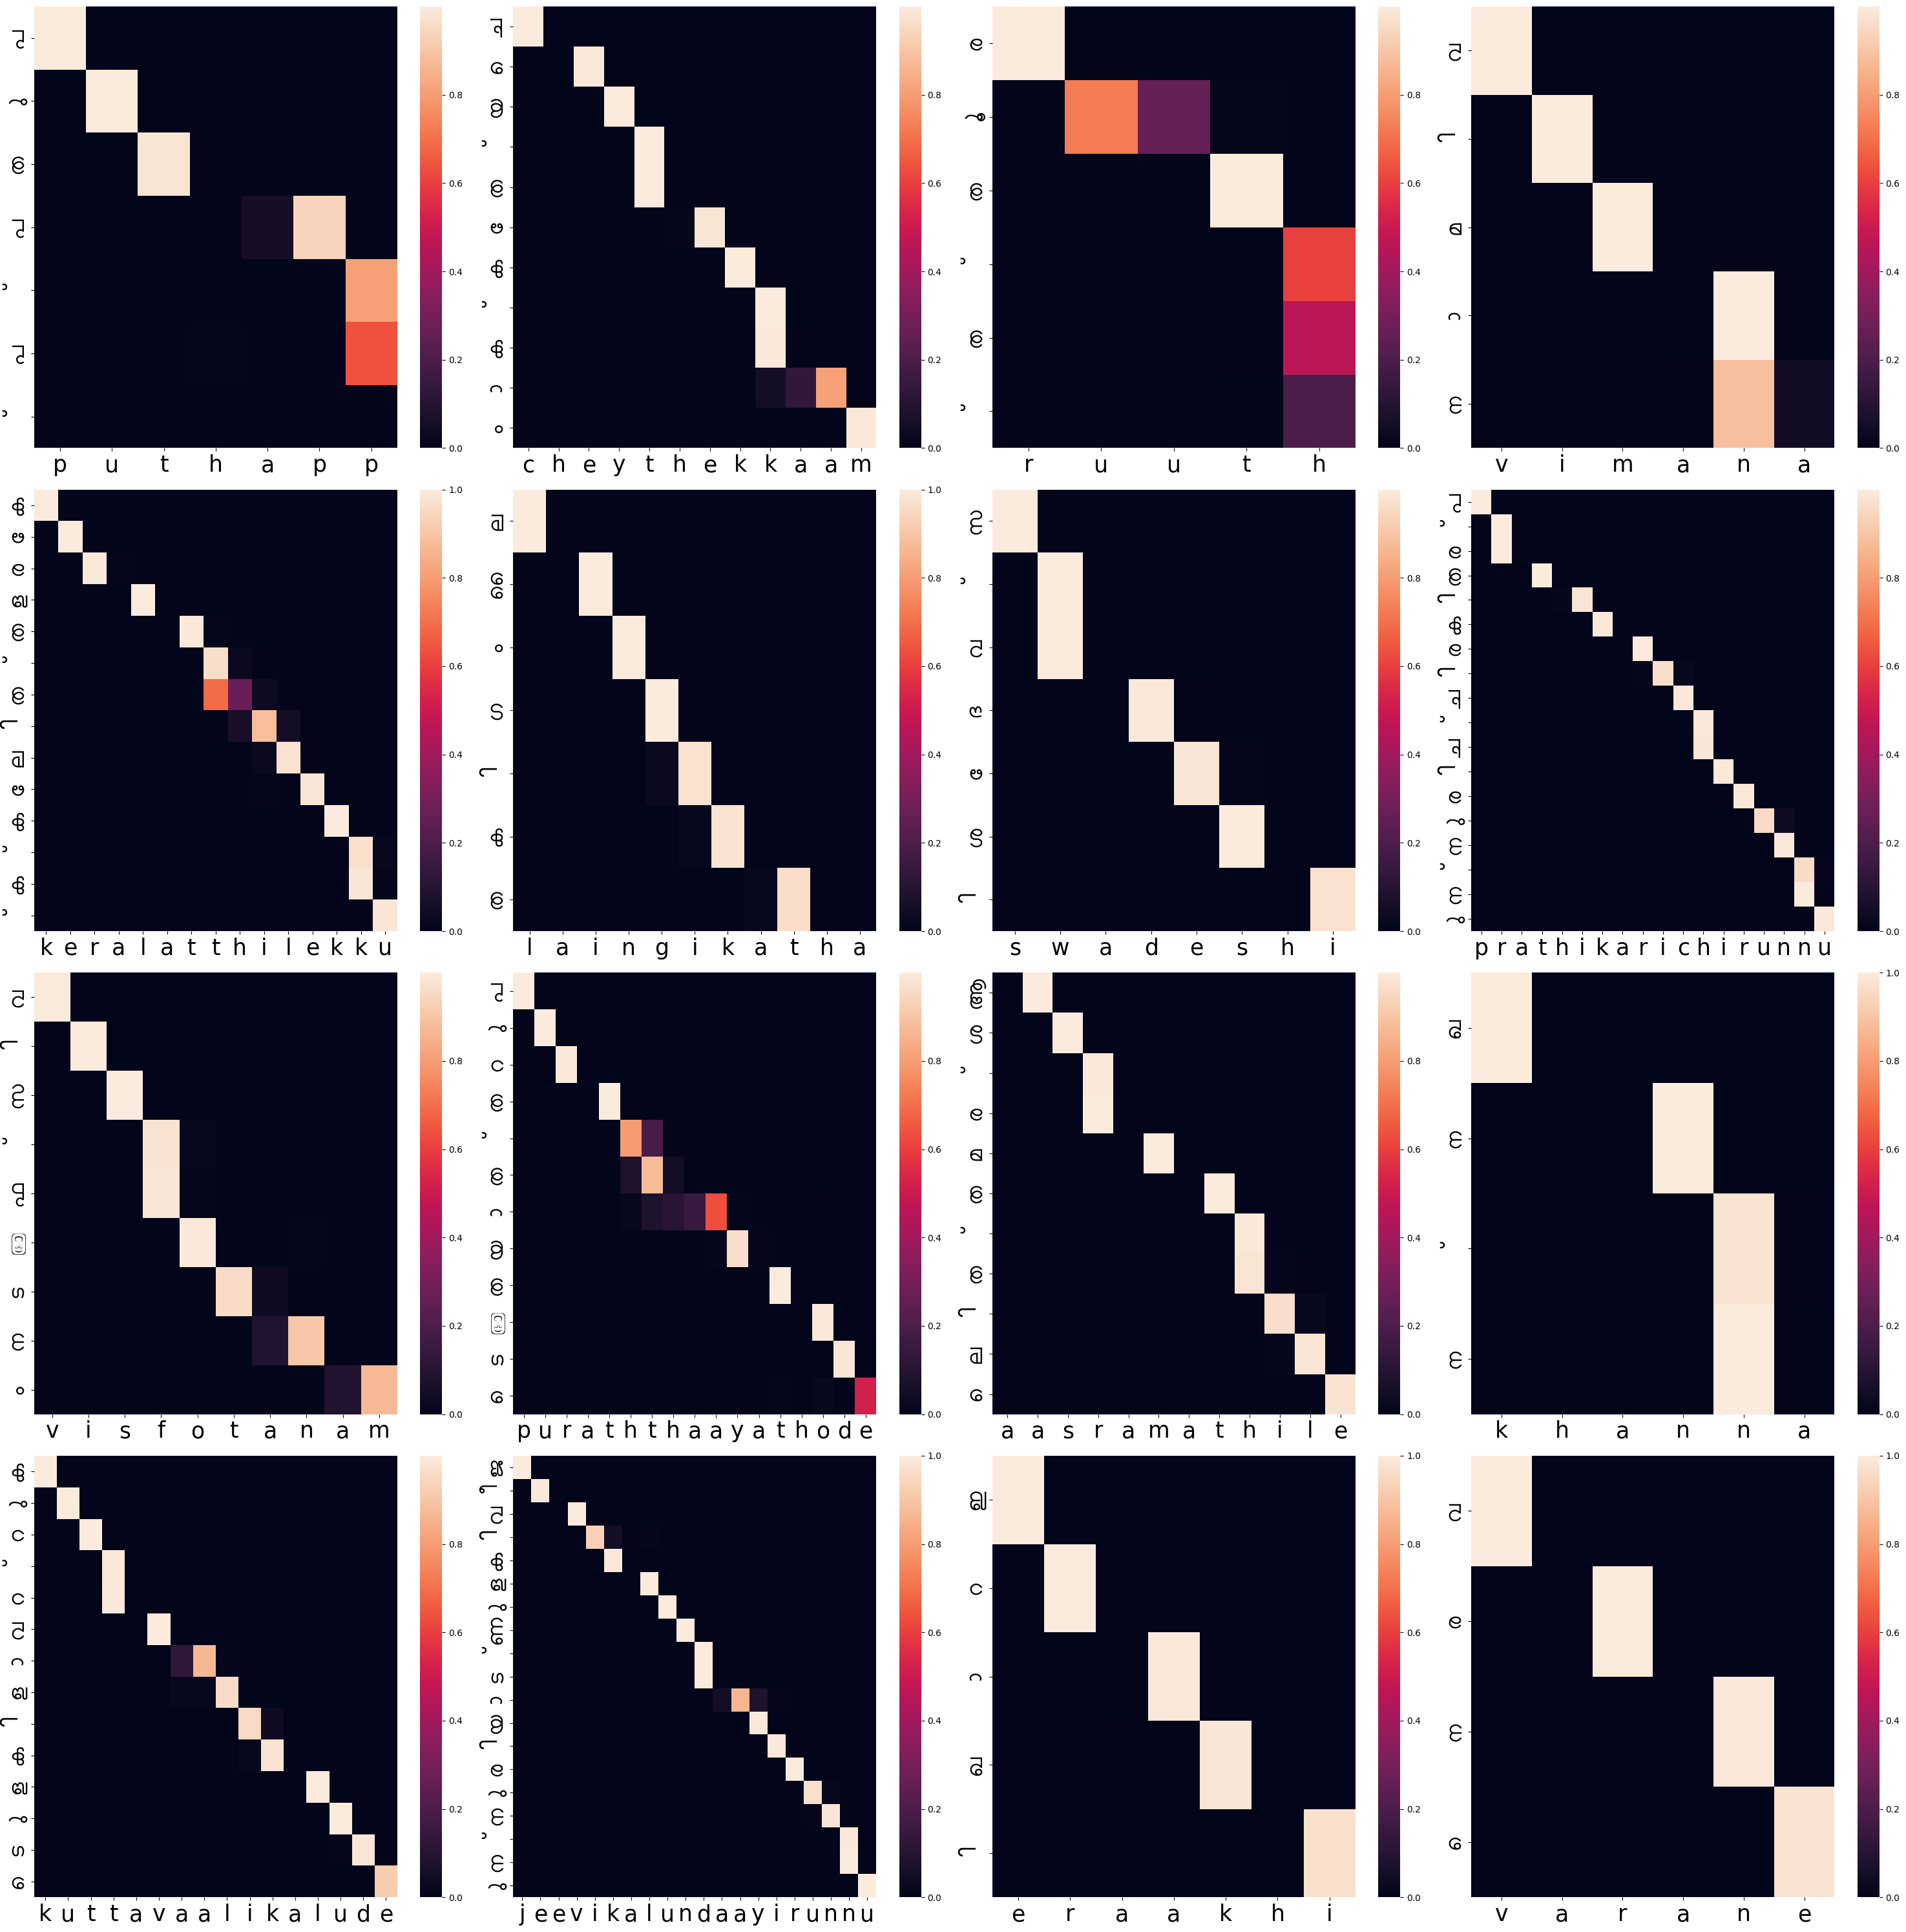

In [40]:
correct_count=0
count=0
fig,axs=plt.subplots(4,4,figsize=(30,30))
for eng,mal in test_data:
    if count==16:
        break
    eng_char=english_character(eng)
    
    
    eng_word=word_finder_eng(eng)
    mal_word=word_finder_mal(mal)

    
    eng=eng.unsqueeze(0).to('cuda')
    mal=mal.unsqueeze(0).to('cuda')
    
    
    pred,attention=model(eng,mal,teacher_force_ratio=0)
    pred=torch.squeeze(pred).cpu().detach().numpy()
    pred=np.argmax(pred,axis=-1)
    predicted=word_finder_mal(pred)
    mal_char=malayalam_character(pred)
    
    if predicted==mal_word:
        col=count%4
        row=count//4
        attention_=attention_map(attention,pred,eng)
        sns.heatmap(attention_, xticklabels=eng_char, yticklabels=mal_char, ax=axs[row, col])
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), fontsize=25)
        axs[row, col].set_yticklabels(axs[row, col].get_yticklabels(), fontproperties=mal_font,fontsize=25)
        count+=1

        
        
plt.tight_layout()
plt.savefig('Attention.png')
plt.show()

    

In [29]:
eng.squeeze(0)

tensor([15, 17, 20, 20, 17, 23, 23, 12,  9,  9, 11,  9,  8,  8,  3,  8,  8, 10,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0',
       dtype=torch.int32)

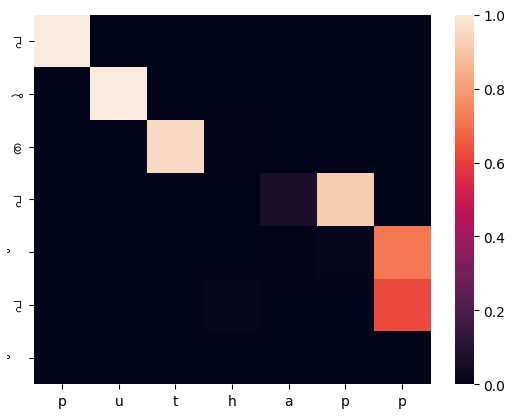

In [21]:
attention_=attention_map(attention,pred,eng)
plt.yticks(fontproperties= mal_font)
hm=sns.heatmap(attention_,xticklabels=eng_char,yticklabels=mal_char)
plt.show()


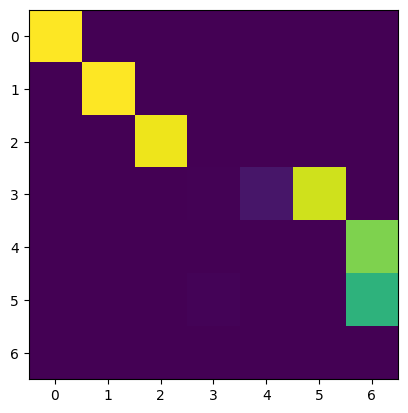

In [42]:
attention_=attention_map(attention,pred,eng)
plt.imshow(attention_)

In [37]:
attention[0].shape

torch.Size([1, 1, 31])